In [86]:
import astropy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from astropy.coordinates.angle_utilities import hms_to_degrees, dms_to_degrees
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u
import re
import json
from collections import Counter
from operator import itemgetter
import scipy
from scipy.signal import argrelextrema

In [87]:
#ОКПЗ
data = astropy.io.ascii.read('gcvs5.txt', data_start=2, delimiter='|')

In [88]:
data = data[['J2000.0', 'Type']]

In [89]:
data = data.to_pandas()

In [90]:
data.Type = data.Type.map(lambda item: re.sub(':', '', str(item) ) if str(item).endswith(':') else str(item) )

In [91]:
data.rename(columns={'J2000.0':'coord'}, inplace=True)

In [92]:
data.drop(index=data[data.coord.map(lambda x: type(x) is not str )].index.values.tolist(), inplace=True)

In [93]:
data = data[ data.coord.map(lambda x: len(str(x)) == 19 ) ]

In [94]:
data['ra'] = data.coord.map(lambda x: x[:9])
data['dec'] = data.coord.map(lambda x: x[9:])

In [95]:
data.dec = data.dec.map(lambda x: x.replace(' ', '') )

In [96]:
data = data[ (data.dec.map(lambda x: x.startswith('+')) | data.dec.map(lambda x: x.startswith('-')) )
            & data.dec.map(lambda x: len(x) == 9 ) ]

In [97]:
data.reset_index(drop=True, inplace=True)

In [98]:
data.ra = data.ra.map(lambda x: hms_to_degrees(float(x[:2]), float(x[2:4]), float(x[4:])) )
data.dec = data.dec.map(lambda x: dms_to_degrees(float(x[:3]), float(x[3:5]), float(x[5:])))

In [99]:
data

,coord,Type,ra,dec
0,002401.95 +383437.3,M,6.008125,38.577028
1,004243.1 +411605.0,SNI,10.679583,41.268056
2,002223.15 +265945.8,M,5.596458,26.996056
3,011529.70 +404308.4,M,18.873750,40.719000
4,005006.28 +353910.1,M,12.526167,35.652806
...,...,...,...,...
54598,194926.98 +213443.6,SRA,297.362417,21.578778
54599,195052.40 +200453.0,SRA,297.718333,20.081389
54600,195208.25 +274220.9,NA,298.034375,27.705806
54601,195921.34 +263847.6,EB,299.838917,26.646556


In [ ]:
#sorted(Counter(data.Type).items(), key=itemgetter(1), reverse=True)

In [19]:
################################################################

In [21]:
###################### request our objects ################

In [100]:
%%time

my_data = pd.DataFrame({'obj_id':[],
                        'filter':[],
                        'mean_magn':[],
                        'amplitude':[],
                        'trand_angle':[],
                        'skew' : [],
                        'std' : [],
                        'max_PSD' : [],
                        'max_fs' : [],
                        'class':[]})

for item in data.iterrows():
    
    try:
        resp = requests.get('http://db.ztf.snad.space/api/v1/circle/full/json?ra={ra}&dec={dec}&radius_arcsec={r}'.format(ra=item[1].ra, 
                                                                                                                          dec=item[1].dec, 
                                                                                                                          r=5))
        res = resp.json()
        for obj_id in res.keys():
            if (res[obj_id]['meta']['filter']=='zg') & (len(res[obj_id]['lc'])>=20):
                obj_mjd = []
                obj_mag = []
                obj_magerr = []
                object_return = {}
                obj_filter = res[obj_id]['meta']['filter']
                
                for ii in res[obj_id]['lc']:
                    obj_mjd.append(ii['mjd'])
                    obj_mag.append(ii['mag'])
                    obj_magerr.append(ii['magerr'])
                
                Fs = 1/((np.array(obj_mjd).max() - np.array(obj_mjd).min() )/np.array(obj_mjd).size)
                f, Pxx = scipy.signal.periodogram(np.array(obj_mag), fs=Fs)
                    
                object_return['obj_id'] = obj_id
                object_return['filter'] = res[obj_id]['meta']['filter']
                # feach ingenering:
                object_return['mean_magn'] = np.array(obj_mag).mean()
                object_return['amplitude'] = np.array(obj_mag).max() - np.array(obj_mag).min()
                object_return['trand_angle'] = np.polyfit(np.array(obj_mjd), np.array(obj_mag), 1)[0] 
                object_return['skew'] = scipy.stats.skew(np.array(obj_mag))
                object_return['std'] = np.array(obj_mag).std()
                object_return['max_PSD'] = Pxx.max()
                object_return['max_fs'] = f[Pxx.argmax()]
                 
                my_data = my_data.append( pd.DataFrame({'obj_id' : [ object_return['obj_id'] ],
                                                      'filter' : [ object_return['filter'] ],
                                                      'mean_magn' :[ object_return['mean_magn'] ],
                                                      'amplitude' : [ object_return['amplitude'] ], 
                                                      'trand_angle' : [ object_return['trand_angle'] ],
                                                      'skew' : [ object_return['skew'] ],
                                                      'std' : [ object_return['std'] ],
                                                      'max_PSD' : [ object_return['max_PSD']],
                                                      'max_fs' : [ object_return['max_fs'] ],
                                                      'class' : [ item[1].Type ] }),
                                         ignore_index = True)
            
    except Exception as ex:
        print("file {} has error".format(item[0]), ex)
    
    if item[0] % 1000 == 0 :
        my_data.to_csv('backup_' + str(item[0]) + '.csv')


file 2720 has error Extra data: line 1 column 5 (char 4)
file 6039 has error Extra data: line 1 column 5 (char 4)
file 7652 has error Extra data: line 1 column 5 (char 4)
file 9645 has error Extra data: line 1 column 5 (char 4)
file 10380 has error Extra data: line 1 column 5 (char 4)
file 10436 has error Extra data: line 1 column 5 (char 4)
file 12345 has error Extra data: line 1 column 5 (char 4)
file 17007 has error Extra data: line 1 column 5 (char 4)
file 24321 has error Extra data: line 1 column 5 (char 4)
file 24378 has error Extra data: line 1 column 5 (char 4)
file 26861 has error Extra data: line 1 column 5 (char 4)
file 30208 has error Extra data: line 1 column 5 (char 4)
file 31744 has error Extra data: line 1 column 5 (char 4)
file 31753 has error Extra data: line 1 column 5 (char 4)
file 31754 has error Extra data: line 1 column 5 (char 4)
file 31756 has error Extra data: line 1 column 5 (char 4)
file 34108 has error Extra data: line 1 column 5 (char 4)
file 34210 has err

file 45945 has error Extra data: line 1 column 5 (char 4)
file 45953 has error Extra data: line 1 column 5 (char 4)
file 45955 has error Extra data: line 1 column 5 (char 4)
file 45975 has error Extra data: line 1 column 5 (char 4)
file 45977 has error Extra data: line 1 column 5 (char 4)
file 45978 has error Extra data: line 1 column 5 (char 4)
file 45982 has error Extra data: line 1 column 5 (char 4)
file 45983 has error Extra data: line 1 column 5 (char 4)
file 45985 has error Extra data: line 1 column 5 (char 4)
file 45986 has error Extra data: line 1 column 5 (char 4)
file 45988 has error Extra data: line 1 column 5 (char 4)
file 45989 has error Extra data: line 1 column 5 (char 4)
file 45992 has error Extra data: line 1 column 5 (char 4)
file 45997 has error Extra data: line 1 column 5 (char 4)
file 46010 has error Extra data: line 1 column 5 (char 4)
file 46022 has error Extra data: line 1 column 5 (char 4)
file 46031 has error Extra data: line 1 column 5 (char 4)
file 46051 has

In [35]:
my_data

,obj_id,filter,mean_magn,amplitude,trand_angle,skew,std,class
0,695111400064435,zg,15.773690,1.453001,0.001723,1.398299,0.289004,SNI
1,696111300007125,zg,14.364000,2.814000,0.010997,-0.184409,0.831350,M
2,650116300021136,zg,13.844756,4.562000,0.014918,-0.331234,1.557293,M
3,739102400006782,zg,13.976114,3.712000,0.021147,-0.069805,1.090874,M
4,650112100009135,zg,15.054762,5.769000,-0.021382,-1.735134,1.443471,M
...,...,...,...,...,...,...,...,...
449,739106200007423,zg,13.514614,0.424000,0.000700,0.315841,0.119177,EW
450,739106300001275,zg,14.498591,0.547000,-0.000106,0.882827,0.149303,EB
451,739106300000319,zg,15.219579,0.684999,0.000891,0.727890,0.237262,EW
452,698107200003917,zg,15.839971,1.131000,-0.001035,1.207431,0.309752,EB


In [102]:
my_data.to_csv('final_data.csv')

In [103]:
df = my_data.copy()

In [ ]:
# leave only popular classes

In [111]:
largest_classes = list(df['class'].value_counts().nlargest(n=8).index)

In [112]:
largest_classes

['M', 'RRAB', 'EW', 'LB', 'EA', 'SR', 'UV', 'SRB']

In [113]:
to_replace = list(set(df['class'].values) - set(largest_classes))

In [114]:
df['class'].replace(list(to_replace), 'OTHER', inplace=True)

In [115]:
df

,obj_id,filter,mean_magn,amplitude,trand_angle,skew,std,max_PSD,max_fs,class
0,695111400064435,zg,15.773690,1.453001,0.001723,1.398299,0.289004,3.399184,0.010275,OTHER
1,696111300007125,zg,14.364000,2.814000,0.010997,-0.184409,0.831350,109.148506,0.004933,M
2,650116300021136,zg,13.844756,4.562000,0.014918,-0.331234,1.557293,389.605181,0.005218,M
3,739102400006782,zg,13.976114,3.712000,0.021147,-0.069805,1.090874,154.242913,0.005060,M
4,650112100009135,zg,15.054762,5.769000,-0.021382,-1.735134,1.443471,221.024325,0.006069,M
...,...,...,...,...,...,...,...,...,...,...
20946,591114400014842,zg,13.061500,1.285000,-0.001683,0.068691,0.432117,26.820901,0.003765,OTHER
20947,591110100121485,zg,15.218951,1.728001,0.002616,0.237410,0.589383,62.899336,0.003765,OTHER
20948,640112100011424,zg,15.961219,0.143001,0.000113,0.147361,0.022942,0.026436,0.007530,OTHER
20949,640111400015183,zg,12.599721,0.497000,-0.000168,0.052068,0.126795,0.615557,0.041414,OTHER


In [116]:
df['class'].value_counts().nlargest(n=9)

OTHER    7500
M        3224
RRAB     2373
EW       1999
LB       1553
EA       1427
SR       1396
UV        819
SRB       660
Name: class, dtype: int64

In [117]:
df.to_csv('prepared_data.csv')

In [ ]:
# time series example 

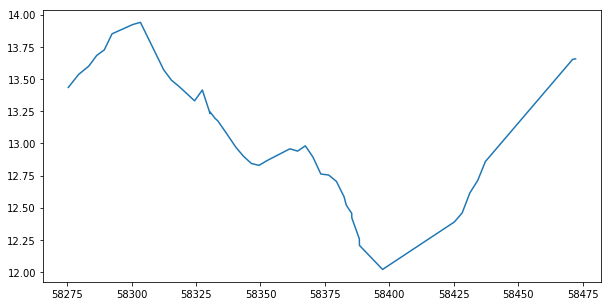

In [482]:
plt.figure(figsize=(10,5))
plt.plot(np.array(obj_mjd), np.array(obj_mag))